In [12]:
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
nltk.download("stopwords")
from nltk.corpus import stopwords
from tqdm import tqdm
import re
import unicodedata
from transformers import AutoTokenizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from numpy import array
import gensim
from gensim.models import KeyedVectors
from gensim.models import word2vec
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import  Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping

[nltk_data] Downloading package stopwords to C:\Users\Fatma
[nltk_data]     Awad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
pip install transformers


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
xml_data = ET.parse("Copy of MUR_sahra_news.xml")
root = xml_data.getroot()

In [15]:
summary=[]
articles = []
for i in root:
    for j in i:
        if j.tag =='summary':
            summary.append(j.text)
        elif j.tag == 'article':
            articles.append(j.text)
articles = articles
summary = summary
df = pd.DataFrame({'Articles': articles, 'Summary': summary})

In [16]:
pip install pandarallel



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
pip install qalsadi


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
pip install pyarabic


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
from pyarabic.araby import strip_tashkeel
from pandarallel import pandarallel
from qalsadi.lemmatizer import Lemmatizer
import qalsadi.lemmatizer


In [8]:
def preprocess_text(text_column):

    def is_arabic(char):
        try:
            return 'ARABIC' in unicodedata.name(char) or char == ' '
        except ValueError:
            return False

    def remove_non_arabic(text):
        return ''.join(char for char in text if is_arabic(char))

    def replace_arabic_with_space(text):
        return ''.join(' ' if is_arabic(char) and char.isdigit() else char for char in text)

    def lemmatize_text(text):
        lemmer = Lemmatizer()
        return lemmer.lemmatize_text(text)

    # Apply Arabic text processing
    text_column = text_column.apply(replace_arabic_with_space)
    text_column = text_column.apply(remove_non_arabic)

    # Separating non-characters with spaces
    text_column = text_column.apply(lambda x: re.sub(r'([^\s\w])', r' \1 ', str(x)))

    # Removing tashkeel
    text_column = text_column.apply(strip_tashkeel)  # Make sure to implement strip_tashkeel

    # Removing repeated characters
    text_column = text_column.apply(lambda x: re.sub(r'(\w)\1+', r'\1', str(x)))

    # Removing stop words
    stop_words = set(stopwords.words("arabic"))
    text_column = text_column.apply(lambda x: " ".join([word for word in str(x).lower().split() if word not in stop_words]))

    # Delete rows where 'review_description' is null
    text_column = text_column.map(lambda x: np.nan if isinstance(x, str) and x.strip() == '' else x)
    text_column.dropna(inplace=True)

    # Initialize parallel Pandas (for parallel apply)
    pandarallel.initialize(progress_bar=True)

    # Apply lemmatization with tqdm
    tqdm.pandas()
    text_column_lemmatized = text_column.parallel_apply(lemmatize_text)

    # Assign the lemmatized text back to the DataFrame
    text_column = text_column_lemmatized

    # Concateniting lemmatized tokens
    text_column = text_column.apply(lambda x: ' '.join(x))


    return text_column

In [ ]:
articles=preprocess_text(df['Articles'])


In [10]:
import pandas as pd

In [11]:
file_path = "updated_file.csv"
Articles = pd.read_csv(file_path, encoding='latin1')

In [12]:
Articles.shape

(11718, 3)

In [4]:
pip install wordcloud matplotlib



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


In [14]:

font_path = 'D:/Text Summarizer/Noto_Nashk_font/static/NotoNaskhArabic-Regular.ttf'
# Word cloud for original text
wordcloud_original = WordCloud(font_path=font_path).generate(' '.join(Articles['original_articles']))

# Word cloud for text after stop words removal
wordcloud_without_stopwords = WordCloud(font_path=font_path).generate(' '.join(Articles['Articles']))


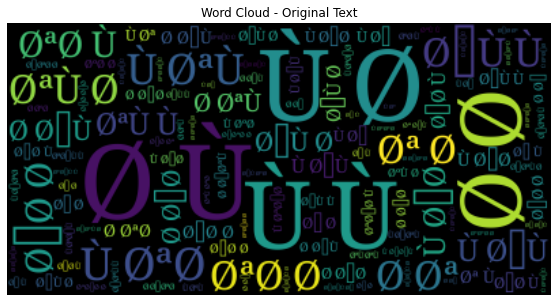

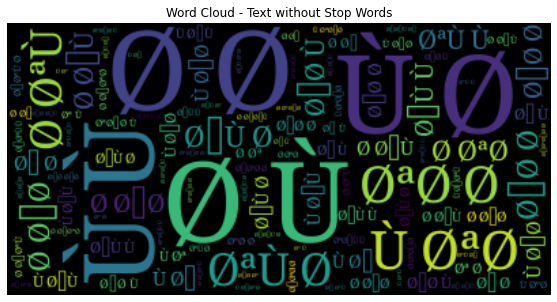

In [15]:

# Plot word cloud for original text
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_original, interpolation='bilinear')
plt.title('Word Cloud - Original Text')
plt.axis('off')
plt.show()

# Plot word cloud for text after stop words removal
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_without_stopwords, interpolation='bilinear')
plt.title('Word Cloud - Text without Stop Words')
plt.axis('off')
plt.show()


In [17]:
max_text_len=125
max_summary_len=40

In [20]:
count = 0
for i in Articles['summaries']:
    if isinstance(i, str) and len(i.split()) <= max_summary_len:
        count += 1

print(count / len(Articles['summaries']))


0.6630824372759857


In [ ]:
dataFrame['Original_Summary'] = dataFrame['Original_Summary'].apply(lambda x : 'sostok '+ x + ' eostok')
dataFrame

,articles_to_encode,Original_Summary
0,وكانت وزير تردي سؤال أحد صحف مؤتمر صحف أسبوع ح...,sostok قالت وزيرة الإسكان والعمران والاستصلاح ...
1,زير ثقاف صناع تقليد علاقة برلمان ، سيد محمد ول...,sostok قدم eostok
2,بدأ هيئة ساحل حمل ندوة ناقش باحث خبراء أسباب ا...,sostok أطلقت هيئة الساحل للدفاع عن حقوق الإنسا...
3,قال شرك عملة الاكتاب أتا تطوير دعم مشاريع متمث...,sostok أعلنت الشركة الموريتانية للمحروقات والأ...
4,مراقب تحدث أشهر ست أولى حكم ولد الغزواني أن كا...,sostok محمد ولد الشيخ الغزواني هو الشخصية الأب...
...,...,...
95,وزارة مستمر اتخاذ وسع إجراء تأمين عود مواطن إس...,sostok قال وزير الشؤون الخارجية والتعاون والمو...
96,معلوم صحراء ميد تقول ولد طالب عمر وقت انتخاب ر...,sostok انتخب حزب الاتحاد من أجل الجمهورية الحا...
97,انتخب حزب نواب رئيس سالك بنت أمر ، محمد أحيا ح...,sostok انتخب المشاركون في مؤتمر حزب الاتحاد من...
98,تقصير مجال نقل ، ترتب حوادث ، أزهق كثير أرواح ...,sostok طالب الفريق البرلماني لأحزاب المعارضة ا...


In [ ]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

In [ ]:
x_train,x_val,y_train,y_val=train_test_split(np.array(dataFrame['articles_to_encode']), np.array(dataFrame['Original_Summary']),
                                       test_size=0.2, random_state=0, shuffle=True)

In [ ]:
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))


In [ ]:
cnt=0
tot_cnt=0
freq=0
tot_freq=0
thresh=4

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:", (cnt/tot_cnt)*100)
print("Total Coverage of rare words:", (freq/tot_freq)*100)

% of rare words in vocabulary: 73.14749470712773
Total Coverage of rare words: 24.790486072312234


In [ ]:
max_text_len = 200
max_summary_len = 128

In [ ]:
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) # num_words: the maximum number of words to keep, based on word frequency.
x_tokenizer.fit_on_texts(list(x_train))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_train)
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_train    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [ ]:
x_voc

762

In [ ]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

In [ ]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 95.55375909458367
Total Coverage of rare words: 65.19950637597697


In [ ]:
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
y_tokenizer.fit_on_texts(list(y_train))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_train)
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val)

#padding zero upto maximum length
y_train    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [ ]:
# # removes data points from your training set where the target sequence has only two non-zero elements,
# ind=[]
# for i in range(len(y_train)):
#     cnt=0
#     for j in y_train[i]:
#         if j!=0:
#             cnt=cnt+1
#     if(cnt==2):
#         ind.append(i)

# y_train=np.delete(y_train,ind, axis=0)
# x_train=np.delete(x_train,ind, axis=0)

In [ ]:
# ind=[]
# for i in range(len(y_val)):
#     cnt=0
#     for j in y_val[i]:
#         if j!=0:
#             cnt=cnt+1
#     if(cnt==2):
#         ind.append(i)

# y_val=np.delete(y_val,ind, axis=0)
# x_val=np.delete(x_val,ind, axis=0)

In [ ]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [ ]:
y_voc

56

In [ ]:
latent_dim = 256
max_seq_length = 128
embedding_dim = 300

encoder_inputs = Input(shape=(max_seq_length,))

encoder_embedding = Embedding(x_voc,embedding_dim,trainable=True)(encoder_inputs)

encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True)
encoder_output1, state_h1, state_c1 = encoder_lstm1(encoder_embedding)

encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17 (InputLayer)       [(None, 128)]                0         []                            
                                                                                                  
 embedding_8 (Embedding)     (None, 128, 300)             228600    ['input_17[0][0]']            
                                                                                                  
 lstm_16 (LSTM)              [(None, 128, 256),           570368    ['embedding_8[0][0]']         
                              (None, 256),                                                        
                              (None, 256)]                                                        
                                                                                           

In [ ]:
x_train_reshaped = x_train[:, :max_seq_length]
y_train_reshaped = y_train[:, :max_seq_length]
print("Shape of x_train_reshaped:", x_train_reshaped.shape)
print("Shape of y_train_reshaped:", y_train_reshaped.shape)
decoder_input_data = y_train_reshaped[:, :-1]  # Remove last element from each sequence
decoder_target_data = np.expand_dims(y_train_reshaped[:,  1:], -1)
print("Shape of decoder_input_data:", decoder_input_data.shape)
print("Shape of decoder_target_data:", decoder_target_data.shape)

In [ ]:
x_val_reshaped = x_val[:, :max_seq_length]
y_val_reshaped = y_val[:, :max_seq_length]

decoder_val_input_data = y_val_reshaped[:, :-1]
decoder_val_target_data = np.expand_dims(y_val_reshaped[:,  1:], -1)

print("Shape of x_val_reshaped:", x_val_reshaped.shape)
print("Shape of decoder_val_input_data:", decoder_val_input_data.shape)
print("Shape of decoder_val_target_data:", decoder_val_target_data.shape)

In [ ]:
history = model.fit([x_train_reshaped, decoder_input_data],
                    decoder_target_data,
                    epochs=10,
                    batch_size=32,
                    validation_data=([x_val_reshaped, decoder_val_input_data], decoder_val_target_data))

Epoch 1/10
3/3 [==============================] - 130s 4s/step - loss: 3.8630 - accuracy: 0.5550 - val_loss: 3.1765 - val_accuracy: 0.9248
Epoch 2/10
3/3 [==============================] - 7s 2s/step - loss: 2.3223 - accuracy: 0.9252 - val_loss: 0.4438 - val_accuracy: 0.9248
Epoch 3/10
3/3 [==============================] - 8s 2s/step - loss: 0.4371 - accuracy: 0.9253 - val_loss: 0.3788 - val_accuracy: 0.9276
Epoch 4/10
3/3 [==============================] - 8s 3s/step - loss: 0.3620 - accuracy: 0.9278 - val_loss: 0.3467 - val_accuracy: 0.9280
Epoch 5/10
3/3 [==============================] - 7s 2s/step - loss: 0.3437 - accuracy: 0.9263 - val_loss: 0.3268 - val_accuracy: 0.9299
Epoch 6/10
3/3 [==============================] - 8s 3s/step - loss: 0.3208 - accuracy: 0.9287 - val_loss: 0.3204 - val_accuracy: 0.9295
Epoch 7/10
3/3 [==============================] - 7s 2s/step - loss: 0.3217 - accuracy: 0.9284 - val_loss: 0.3200 - val_accuracy: 0.9295
Epoch 8/10
3/3 [=======================

In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [ ]:
encoder_model = Model(encoder_inputs, [encoder_outputs, state_h, state_c])


In [ ]:
# Define the decoder input states
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Get the decoder LSTM outputs and states
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(dec_emb, initial_state=decoder_states_inputs)
decoder_states = [state_h_dec, state_c_dec]

# Define the decoder model
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)


In [ ]:
def decode_sequence(input_seq):
    # Trim or pad the input sequence to match max_seq_length
    input_seq = pad_sequences([input_seq], maxlen=max_seq_length, padding='post')

    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence


In [ ]:

def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
print("Encoder vocabulary size:", x_voc)
print("Decoder vocabulary size:", y_voc)



Encoder vocabulary size: 762
Decoder vocabulary size: 56


In [ ]:
!pip install rouge

In [ ]:
from rouge import Rouge

# Initialize Rouge
rouge = Rouge()

# Lists to store reference and predicted summaries
reference_summaries = []
predicted_summaries = []

# Generate reference and predicted summaries
for i in range(0,  3):
    # Print review and original summary
    print("Review:", seq2text(x_train_reshaped[i]))
    print("Original summary:", seq2summary(y_train[i]))

    # Reshape the input sequence directly to shape (1,  128)
    input_seq = x_train_reshaped[i].reshape((1,  128))


    # Generate predicted summary
    predicted_summary = decode_sequence(input_seq)
    print("Predicted summary:", predicted_summary)
    print("\n")

    # Append reference summary and predicted summary to lists
    reference_summaries.append(seq2summary(y_train[i]))
    predicted_summaries.append(predicted_summary)

# Compute ROUGE scores
scores = rouge.get_scores(predicted_summaries, reference_summaries, avg=True)

# Print ROUGE scores
print("ROUGE Scores:", scores)


In [ ]:
ROUGE Scores: {'rouge-1': {'r': 0.125, 'p': 0.3333333333333333, 'f': 0.17777777522962968},
               'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0},
               'rouge-l': {'r': 0.125, 'p': 0.3333333333333333, 'f': 0.17777777522962968}}

In [ ]:
embedding_layer = decoder_model.get_layer("embedding_5")
vocab_size = embedding_layer.input_dim
print("Embedding layer vocabulary size:", vocab_size)

Embedding layer vocabulary size: 56


In [ ]:
for i in range(0, 3):
    print("Review:", seq2text(x_train_reshaped[i]))
    print("Original summary:", seq2summary(y_train[i]))
    # Reshape the input sequence directly to shape (1, 128)
    input_seq = x_train_reshaped[i].reshape((1, 128))
    print("Predicted summary:", decode_sequence(input_seq))
    print("\n")
